Selecting GPU to use

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
import os
import tensorflow as tf

# Specify the GPU you want to use (e.g., "0" for the first GPU)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Verify TensorFlow can see the specified GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Number of Physical GPUs: {len(gpus)}, Number of Logical GPUs: {len(logical_gpus)}")
        
        # Print the name of the GPU being used
        for gpu in gpus:
            print(f"GPU Name: {gpu.name}")
            
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found.")


Number of Physical GPUs: 1, Number of Logical GPUs: 1
GPU Name: /physical_device:GPU:0


In [3]:
import tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12319975309550664599
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 32648855552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9073258970478239531
physical_device_desc: "device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:65:00.0, compute capability: 7.0"
xla_global_id: 416903419
]


Importing Libraries

In [4]:
import os
import numpy as np
import datapipeline # file named datapipeline cosisting of our custom dataloader
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

Initializing Data loader

In [5]:
##############################################################
#Define the image generators for training and validation
train_img_dir = "/home/abul/Downloads/input_data_128/train/images/"
train_mask_dir = "/home/abul/Downloads/input_data_128/train/masks/"

val_img_dir = "/home/abul/Downloads/input_data_128/val/images/"
val_mask_dir = "/home/abul/Downloads/input_data_128/val/masks/"

train_img_list=sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list=sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))


batch_size = 4

train_img_datagen = datapipeline.imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = datapipeline.imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

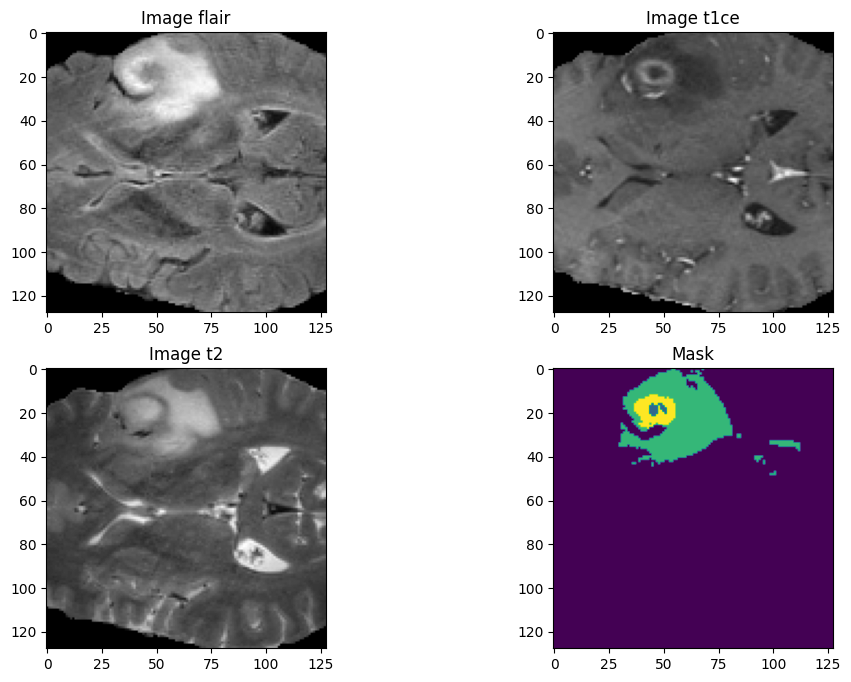

In [6]:
# Verify generator
img, msk = train_img_datagen.__next__()

img_num = int(input("Enter num of image you wan to view : ")) #only enter number in range of batch size here its 2 [0,1]
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=int(input("Enter slice number : ")) # 0 - 128 
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


Defining Loss and Optimizers

In [14]:
#Define loss, metrics and optimizer to be used for training
import losses
def loss(y_true, y_pred):

    return 0.5 * losses.BCELoss(y_true, y_pred) + 0.5 * losses.TverskyLoss(losses.alpha, losses.beta)(y_true, y_pred)
    # to modify alpha and beta go to losses.py current alpha,beta = 0.5,0.5
    # u can set alpha > beta to penalize false negatives
# Define metrics
num_classes = 4
metrics = [
    'accuracy',
    tf.keras.metrics.MeanIoU(num_classes=num_classes),
    tf.keras.metrics.IoU(num_classes=num_classes, target_class_ids=[0, 1, 2, 3])
]

LR = 0.0001
optimizer= keras.optimizers.Adam(LR)

Initializing the model

In [15]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

from  UNET_V1 import UNET
model = UNET(IMG_HEIGHT=128, 
            IMG_WIDTH=128, 
            IMG_DEPTH=128, 
            IMG_CHANNELS=3, 
            num_classes=4)

model.compile(optimizer = optimizer, loss=loss, metrics=metrics)

Training

In [16]:
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='The operation took')

history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/100


/home/abul/miniforge3/envs/tf/lib/python3.9/site-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


60/60 ━━━━━━━━━━━━━━━━━━━━ 520s 8s/step - accuracy: 0.4288 - io_u_2: 0.2919 - loss: 0.7454 - mean_io_u_2: 0.2919 - val_accuracy: 0.9472 - val_io_u_2: 0.3779 - val_loss: 0.4807 - val_mean_io_u_2: 0.3779
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 491s 8s/step - accuracy: 0.9519 - io_u_2: 0.4884 - loss: 0.4270 - mean_io_u_2: 0.4884 - val_accuracy: 0.9545 - val_io_u_2: 0.4991 - val_loss: 0.3963 - val_mean_io_u_2: 0.4991
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 491s 8s/step - accuracy: 0.9517 - io_u_2: 0.4947 - loss: 0.3894 - mean_io_u_2: 0.4947 - val_accuracy: 0.9537 - val_io_u_2: 0.4922 - val_loss: 0.3628 - val_mean_io_u_2: 0.4922
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 491s 8s/step - accuracy: 0.9489 - io_u_2: 0.4966 - loss: 0.3758 - mean_io_u_2: 0.4966 - val_accuracy: 0.9604 - val_io_u_2: 0.4998 - val_loss: 0.3437 - val_mean_io_u_2: 0.4998
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 491s 8s/step - accuracy: 0.9492 - io_u_2: 0.4970 - loss: 0.3584 - mean_io_u_2: 0.4970 - val_accuracy: 0.9544 - val_io

Saving Results

In [ ]:
import csv
# Define a list to store training results
training_results = []

epochs = range(1, len(history.history['accuracy']) + 1)
training_accuracy = history.history['accuracy']
training_iou_score = history.history['iou_score']
training_mean_iou = history.history['mean_io_u']  # Adjust the metric name as needed

validation_results = []
validation_accuracy = history.history['val_accuracy']
validation_iou_score = history.history['val_iou_score']
validation_mean_iou = history.history['val_mean_io_u']  # Adjust the metric name as needed

# Append the training results to the list
for epoch, training_acc, training_iou_score, training_miou, val_acc, val_iou_score, val_miou in zip(epochs, training_accuracy, training_iou_score,training_mean_iou, validation_accuracy, validation_iou_score, validation_mean_iou):
    training_results.append([epoch, training_acc, training_iou_score, training_miou, val_acc, val_iou_score, val_miou])

# Define the training CSV file path
training_csv_file = 'training_and_val_metrics.csv'

# Write the training results to a CSV file
with open(training_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training accuracy', 'Training iou_score', 'Training Mean IOU',  'Validation accuracy', 'Validation iou_score', 'Validation Mean IOU'])
    writer.writerows(training_results)

print(f'Training results saved to {training_csv_file}')

In [ ]:
import pandas as pd
df = pd.read_csv(training_csv_file)
print(df)

Testing

In [ ]:
test_img_dir = "test/images/"
test_mask_dir = "test/masks/"

test_img_list = sorted(os.listdir(test_img_dir))
test_mask_list = sorted(os.listdir(test_mask_dir))

batch_size=2
test_img_datagen = datapipeline.imageLoader(test_img_dir, test_img_list,  test_mask_dir, test_mask_list, batch_size)
test_steps_per_epoch =(len(test_img_list)//batch_size )+1 

test_loss, test_accuracy, iou_score, mean_iou = model.evaluate(
    test_img_datagen, 
    steps = test_steps_per_epoch, 
    verbose=1
)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test IoU Score: {iou_score}')
print(f'Test Mean IoU: {mean_iou}')

In [ ]:
def dice_score(o, t, eps=1e-8):
    num = 2*(o*t).sum() + eps
    den = o.sum() + t.sum() + eps
    return num/den

def softmax_output_dice(target,output):
    ret = []
    
    # whole   wt
    o = output > 0; t = target > 0 # ce
    ret += dice_score(o, t),
    
    # core   tc
    o = (output == 1) | (output == 3)
    t = (target == 1) | (target == 3)
    ret += dice_score(o, t),
    
    # active   et
    o = (output == 3);t = (target == 3)
    ret += dice_score(o, t),

    return ret


dice_scores_wt = []
dice_scores_tc = []
dice_scores_et = []
num_classes = 4

for batch in range(test_steps_per_epoch):
    
    test_img, test_mask = next(test_img_datagen)
    test_prediction = model.predict(test_img)
    
    test_mask_argmax=np.argmax(test_mask, axis=4)[0,:,:,:]
    test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]
    
    tensor = softmax_output_dice(test_mask_argmax, test_prediction_argmax)
    dice_batch = tensor[0]
    dice_scores_wt.append(dice_batch)
    dice_scores_tc.append(tensor[1])
    dice_scores_et.append(tensor[2])


print("Dice Scores for Unet trained for 100 epochs with dice loss : ")
average_dice_score_et = sum(dice_scores_et) / len(dice_scores_et)
print("Average Dice Score et:", average_dice_score_et)
average_dice_score_wt = sum(dice_scores_wt) / len(dice_scores_wt)
print("Average Dice Score wt:", average_dice_score_wt)
average_dice_score_tc = sum(dice_scores_tc) / len(dice_scores_tc)
print("Average Dice Score tc:", average_dice_score_tc)



import csv

# Define the test results
average_dice_scores = [
    ['Enhanced Tumor', average_dice_score_et],
    ['Whole Tumor', average_dice_score_wt],
    ['Tumor Core', average_dice_score_tc]
]

# Define the CSV file path
test_csv_file = 'dice_scores.csv'

# Write the test results to a CSV file
with open(test_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(average_dice_scores)

print(f'dice scores results saved to {test_csv_file}')

In [ ]:
import pandas as pd
df = pd.read_csv(test_csv_file)
print(df)

Saving Model Weights

In [ ]:
model.save('V-1.hdf5')